In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pk
import os,glob,re
import tifffile
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.patches import Wedge

In [2]:
cd "~/PycharmProjects/IMyG_2/"

/Users/jz-rolling/PycharmProjects/IMyG_2


In [3]:
import IMyG as im

In [5]:
def pool_data(input_folder):
    pooled = []
    files = glob.glob(input_folder+"*.pk")
    if len(files) == 0:
        print("No pickled file found!")
    else:
        for file in files:
            pooled += pk.load(open(file,'rb'))
    return pooled
    
def pad_data(array,length,max_len = 15,max_pixel=512,normalize = True,base = 50):
    pixelated_length = int(round(length*max_pixel*0.5/max_len))*2
    pad_length = int((max_pixel-pixelated_length)/2)
    interpolated = np.interp(np.linspace(0,1,pixelated_length),\
                             np.linspace(0,1,len(array)),array)
    if normalize:
        interpolated = (interpolated-interpolated.min()+base)/(interpolated.max()-interpolated.min()+base)
    padded = np.pad(interpolated,(pad_length,pad_length),'constant', constant_values=(0,0))
    return padded

def moving_window_average(data,window_size = 5):
    if len(data) <= window_size+2:
        raise ValueError("Input array does not have enough values")
    else:
        cum_sum = np.cumsum(np.insert(data,0,0))
        return ((cum_sum[window_size:]-cum_sum[:-window_size])/float(window_size))

def measure_variability(data,cut_off = 10,percentile = 90):
    val = np.log10(data[data >= np.percentile(data,percentile)].mean()/data.mean())
    if val > 1:
        val = 1
    return round(val,3)

def center_of_mass(data,xcor):
    center = np.sum((data)*xcor)/np.sum((data))
    return np.round(center,3)

def normalize_array(data,min_val,max_val,base=0):
    return((data-min_val+base)/(max_val-min_val+base))

def weighted_segmentation(data,quantile_filter = 0.05,weighted_center = True):
    if quantile_filter:
        min_threshould = np.quantile(data,quantile_filter)
    else:
        min_threshould = 0
    filtered_data = data.copy()
    normalized_data = normalize_array(filtered_data,min_threshould,filtered_data.max())
    normalized_data[filtered_data<=min_threshould] = 0.0
    xcor = np.linspace(0,1,len(normalized_data))
    if weighted_center:
        com_0 = center_of_mass(normalized_data,xcor)
    else:
        com_0 = 0.5
    adjusted_center_dist_1 = int(com_0*len(normalized_data))
    adjusted_center_dist_2 = len(normalized_data) - adjusted_center_dist_1
    first_half = normalized_data[:adjusted_center_dist_1]
    xcor_first = xcor[:adjusted_center_dist_1]
    second_half = normalized_data[-adjusted_center_dist_2:]
    xcor_second = xcor[-adjusted_center_dist_2:]
    com_1 = center_of_mass(first_half,xcor_first)
    com_2 = center_of_mass(second_half,xcor_second)
    com_dist = com_2-com_1
    return [com_1,com_0,com_2],round(com_dist,3)

def segmented_mean(data,quantile_filter = 0.05,weighted_center = True):
    smoothed = moving_window_average(data)
    interpolated = np.interp(np.linspace(0,1,200),np.linspace(0,1,len(data)),data)
    smoothed = moving_window_average(interpolated)
    [c1,c2,c3],c_dist = weighted_segmentation(smoothed,\
                                              quantile_filter=quantile_filter,\
                                              weighted_center=weighted_center)
    n_points = len(smoothed)
    c1,c2,c3 = int(c1*n_points),int(c2*n_points),int(c3*n_points)
    l1,l2,r1,r2 = smoothed[:c1].mean(),smoothed[c1:c2].mean(),smoothed[c2:c3].mean(),smoothed[c3:].mean()
    h1,h2 = smoothed[:c2].mean(),smoothed[c2:].mean()
    pole,center = np.concatenate([smoothed[:c1],smoothed[c3:]]).mean(),\
                  smoothed[c1:c3].mean()
    return(l1,l2,r1,r2,h1,h2,pole,center)

def measure_symmetry(p1,p2):
    if p1>p2:
        return round(p2/p1,3)
    else:
        return round(p1/p2,3)

def measure_centrifugality(pole,center):
    return(round(np.log2(pole/center),3))

def measure_membrane_idx(data,quantile_filter = 0.2,weighted_center = True,window = 2):
    interpolated = np.interp(np.linspace(0,1,100),np.linspace(0,1,len(data)),data)
    smoothed = moving_window_average(interpolated)
    [c1,c2,c3],c_dist = weighted_segmentation(smoothed,\
                                              quantile_filter=quantile_filter,\
                                              weighted_center=weighted_center)
    n_points = len(smoothed)
    w = window
    c1,c2,c3 = int(c1*n_points),int(c2*n_points),int(c3*n_points)
    #print(c1,c2,c3)
    v1 = smoothed[max(0,c1-window):min(len(smoothed),c1+window)].mean()
    v2 = smoothed[max(0,c2-window):min(len(smoothed),c2+window)].mean()
    v3 = smoothed[max(0,c3-window):min(len(smoothed),c3+window)].mean()
    ratio = round(np.average([v1,v3])/v2,3)
    return ratio,c_dist

def standardize_well(row,col):
    return(row+str(col).zfill(2))

def initiate_plate(rows,cols,well_width = 4):
    row_idx = ["A","B","C","D","E","F","G","H"]
    col_idx = [1,2,3,4,5,6,7,8,9,10,11,12]
    ax_dict = {}
    if (rows)>8 or (cols)>12:
        raise ValueError("384 well plate is not currently supported!")
    else:
        print(rows,cols)
        fig = plt.figure(figsize=(cols,rows))
        gs = GridSpec(rows*well_width,cols*well_width)
        for r in range(0,rows):
            for c in range(0,cols):
                well = standardize_well(row_idx[r],col_idx[c])
                ax = fig.add_subplot(gs[r*well_width:r*well_width+well_width,\
                                                   c*well_width:c*well_width+well_width])
                circ = plt.Circle((0.5,0.5),0.5,fill=False)
                ax.add_artist(circ)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                if r == 0:
                    ax.set_title(str(col_idx[c]),fontsize = 12)
                if c == 0:
                    ax.get_yaxis().set_visible(True)
                    ax.tick_params(top=False,bottom=False,left=False,right=False,\
                                   labelleft=False,labelbottom=False)
                    ax.set_ylabel(row_idx[r]+"  ",rotation=0,position = (0,0.4),fontsize=12)
                ax_dict[well] = ax
    return fig,ax_dict

def convert_to_color(normalized_val):
    if normalized_val>1 or normalized_val<0:
        raise ValueError("Value needs to be normalized!")
    else:
        cmap = cm.get_cmap("Blues")
        return cmap(normalized_val)

def draw_well(axes,well_id,values):
    if not well_id in axes:
        raise ValueError("Well id not found!")
    else:
        n_wedges = len(values)
        for i in range(len(values)):
            val = values[i]
            ang0,ang1 = (360/n_wedges)*i,(360/n_wedges)*(i+1)
            w = Wedge((0.5,0.5),0.45,ang0,ang1,fc=convert_to_color(val))
            axes[well_id].add_artist(w)
            
def normalize_SNR(SNR):
    normalized_SNR = SNR*0.1
    if normalized_SNR < 0.1:
        normalized_SNR = 0.1
    if normalized_SNR > 1.0:
        normalized_SNR = 1.0
    return(normalized_SNR)

In [6]:
def create_metrics(pooled_data,output_path,well_info):
    padded_fl_axial = []
    fl_lateral=[]
    data_output = []
    temp = True
    counter = 0
    column_name = ["Index","Image","Colony","Cell","Curvature","Length [um]","Cell width mean [um]",\
                   "Cell width std [um]","Perimeter [um]","Fluorescent intensity mean","Fluorescent intensity std",\
                   "SNR","Membrane index","Centrifugality","Signal variability","Signal variability on membrane",\
                   "Body symmetry","Pole symmetry"]
    for cell in pooled_data:
        try:
        #if temp:
            #Cell length:
            cell_length = np.round(cell.length,2)
            #Cell width:
            cell_width = cell.width*cell.pixel_microns
            #Ignore cell caps when measuring the mean of cell width,
            cell_width_mean = round(np.mean(cell_width[5:-5]),2)
            cell_width_std = round(np.std(cell_width),2)
            #Perimeter:
            cell_perimeter = round(cell.perimeter_precise,2)
            #Basic fluroescence metrics
            cell_fluorescent_intensity_mean = round(cell.mean_fl_intensity["FITC"],1)
            cell_fluorescent_intensity_std = round(np.std(cell.fl_img["FITC"][cell.mask>0]),1)
            cell_fluorescent_SNR = round(cell.SNR["FITC"],2)
            #Measure along midline
            midline_measure = im.helper_func.straighten_cell(cell.fl_img["FITC"],cell.mask,cell.midline,\
                                                             half_width_by_pixel=3)
            midline_average = np.average(midline_measure,axis=0)
            half_cell = int(0.5*len(midline_average))
            if midline_average[:half_cell].mean() < midline_average[-half_cell:].mean():
                midline_average = np.flip(midline_average)
            #Measure along lateral axis
            fl_straighten_lateral = cell.fl_straighten["FITC"][0]
            #Measure along contour
            fl_contour = cell.measure_along_contour["FITC"]
            #Membrane idx
            _r,membrane_idx = measure_membrane_idx(fl_straighten_lateral)
            #Segmentate cells based on weighted centers
            l1,l2,r1,r2,h1,h2,pole,center = segmented_mean(midline_average)
            #Measure centrifugality along cell axis
            centrifugality = measure_centrifugality(pole,center)
            variability_axial = measure_variability(midline_average)
            variability_contour = measure_variability(fl_contour) 
            #Measure symmetry
            body_symmetry = measure_symmetry(h1,h2)
            pole_symmetry = measure_symmetry(l1,r2)
            #Create info_table
            data = [counter,cell.plate_idx,cell.colony_label,cell.cell_label,cell.curvature,\
                    cell_length,cell_width_mean,cell_width_std,cell_perimeter,cell_fluorescent_intensity_mean,\
                    cell_fluorescent_intensity_std,cell_fluorescent_SNR,membrane_idx,centrifugality,\
                    variability_axial,variability_contour,body_symmetry,pole_symmetry]
            padded_fl_axial.append(pad_data(midline_average,cell.length,normalize=True))
            fl_lateral.append(np.interp(np.linspace(0,1,100),\
                                        np.linspace(0,1,len(fl_straighten_lateral)),\
                                        fl_straighten_lateral))
            data_output.append(data)
            counter += 1
        except:
            continue
    df = pd.DataFrame(data_output,columns=column_name)
    df.to_excel(output_path+well_info+"_summary.xls")
    np.save(output_path+well_info+"_padded_demograph.npy",np.array(padded_fl_axial),allow_pickle=True)
    np.save(output_path+well_info+"_mean_lateral.npy",np.array(fl_lateral),allow_pickle=True)
    return df,np.array(padded_fl_axial),np.array(fl_lateral)

In [7]:
#global_data
wells = []
global_data = []
#plates = glob.glob("/Volumes/Sam/MSR13_IDW/")
plates = ["/Volumes/Sam/MSR13_IDW/"]
for plate in plates:
    plate_name = plate.split("/")[-2][:-4]
    subfolder = glob.glob(plate+"*raw_files/")[0]
    if len(glob.glob(subfolder+"*raw_files/")) > 0:
        babyfolders = glob.glob(subfolder+"*raw_files/")
        for babyfolder in babyfolders:
            wells = glob.glob(babyfolder+"output/Well*/")
            batch = babyfolder.split("/")[-2][:-10]
            if len(wells)>0:
                for well in wells:
                    data = pool_data(well)
                    well_id = well.split("/")[-2]
                    print(plate,batch,well_id)
                    create_metrics(data,well,well_id)
    else:
        wells = glob.glob(subfolder+"output/Well*/")
        batch = subfolder.split("/")[-2][:-10]
        if len(wells)>0:
            for well in wells:
                data = pool_data(well)
                well_id = well.split("/")[-2]
                print(plate,batch,well_id)
                create_metrics(data,well,well_id)

/Volumes/Sam/MSR13_IDW/ 10182019 Well_A02
/Volumes/Sam/MSR13_IDW/ 10182019 Well_A04
/Volumes/Sam/MSR13_IDW/ 10182019 Well_A07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_B02
/Volumes/Sam/MSR13_IDW/ 10182019 Well_B04
/Volumes/Sam/MSR13_IDW/ 10182019 Well_B07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_C02
/Volumes/Sam/MSR13_IDW/ 10182019 Well_C03
/Volumes/Sam/MSR13_IDW/ 10182019 Well_C04
/Volumes/Sam/MSR13_IDW/ 10182019 Well_C07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_D02
/Volumes/Sam/MSR13_IDW/ 10182019 Well_D03
/Volumes/Sam/MSR13_IDW/ 10182019 Well_D04
/Volumes/Sam/MSR13_IDW/ 10182019 Well_D07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_E01
/Volumes/Sam/MSR13_IDW/ 10182019 Well_E04
/Volumes/Sam/MSR13_IDW/ 10182019 Well_F05
/Volumes/Sam/MSR13_IDW/ 10182019 Well_F07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_G02
/Volumes/Sam/MSR13_IDW/ 10182019 Well_G03
/Volumes/Sam/MSR13_IDW/ 10182019 Well_G06
/Volumes/Sam/MSR13_IDW/ 10182019 Well_G07
/Volumes/Sam/MSR13_IDW/ 10182019 Well_H01
/Volumes/Sam/MSR13_IDW/ 10182019 W

In [8]:
#global_data
wells = []
global_data = []
plates = glob.glob("/Volumes/Sam/MSR*_IDW/")
for plate in plates:
    plate_name = plate.split("/")[-2][:-4]
    subfolder = glob.glob(plate+"*raw_files/")[0]
    if len(glob.glob(subfolder+"*raw_files/")) > 0:
        babyfolders = glob.glob(subfolder+"*raw_files/")
        for babyfolder in babyfolders:
            wells = glob.glob(babyfolder+"output/Well*/")
            batch = babyfolder.split("/")[-2][:-10]
            if len(wells)>0:
                for well in wells:
                    df = pd.read_excel(glob.glob(well+"*summary.xls")[0])
                    count = len(df)
                    sample_id = "{}_{}_{}".format(plate_name,batch,well.split("/")[-2])
                    val_mean = df.describe().iloc[1]
                    val_mean["Count"] = count
                    val_mean["Sample_id"] = sample_id
                    global_data.append(val_mean)
    else:
        wells = glob.glob(subfolder+"output/Well*/")
        batch = subfolder.split("/")[-2][:-10]
        if len(wells)>0:
            for well in wells:
                df = pd.read_excel(glob.glob(well+"*summary.xls")[0])
                count = len(df)
                sample_id = "{}_{}_{}".format(plate_name,batch,well.split("/")[-2])
                val_mean = df.describe().iloc[1]
                val_mean["Count"] = count
                val_mean["Sample_id"] = sample_id
                global_data.append(val_mean)

In [11]:
stupid_list = []
for item in global_data:
    stupid_list.append(item.values)

In [12]:
final_glob = pd.DataFrame(stupid_list,columns=item.index)

In [13]:
final_glob.to_excel("/Users/jz-rolling/Desktop/summary/global_data.xls")

In [14]:
final_glob = pd.read_excel("/Users/jz-rolling/Desktop/summary/global_data.xls")
total_cells = final_glob["Count"].sum()
metrics = final_glob.columns[4:-2]
count_list = final_glob["Count"]
metrics

Index(['Curvature', 'Length [um]', 'Cell width mean [um]',
       'Cell width std [um]', 'Perimeter [um]', 'Fluorescent intensity mean',
       'Fluorescent intensity std', 'SNR', 'Membrane index', 'Centrifugality',
       'Signal variability', 'Signal variability on membrane', 'Body symmetry',
       'Pole symmetry'],
      dtype='object')

In [15]:
global_mean_dict = {}
for metric in metrics:
    data = final_glob[metric]*count_list
    global_mean_dict[metric] = [data.sum()/total_cells,final_glob[metric].std()]

In [17]:
global_mean_dict

{'Curvature': [25.577925275913586, 1.4191748127056407],
 'Length [um]': [4.656761946335513, 0.4217023221481071],
 'Cell width mean [um]': [0.6816433933969759, 0.03621293851027908],
 'Cell width std [um]': [0.10460546758837462, 0.006703606703217194],
 'Perimeter [um]': [10.06521691768721, 0.844679972233365],
 'Fluorescent intensity mean': [199.8093256079118, 134.45216996596884],
 'Fluorescent intensity std': [109.8954264486756, 103.507818528059],
 'SNR': [4.700759875833489, 2.3041751117534353],
 'Membrane index': [0.32034304497378474, 0.014383902499081086],
 'Centrifugality': [-0.21308324467704465, 0.14241113714184825],
 'Signal variability': [0.15970008889482584, 0.06028034694398751],
 'Signal variability on membrane': [0.29451608614687846, 0.03833582294889939],
 'Body symmetry': [0.863615910742598, 0.05751987286151361],
 'Pole symmetry': [0.8260113265366166, 0.06449677224995547]}

In [44]:
filtered_data = final_glob[(final_glob["Count"]>50) & (final_glob["SNR"]>3)]

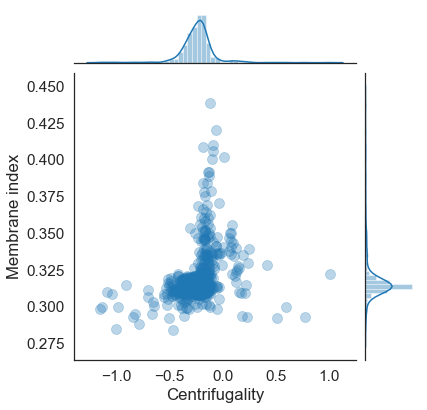

In [91]:
sns.set(font_scale = 1.4,style ="white")
plot1 = sns.JointGrid(x='Centrifugality',y="Membrane index",data=filtered_data)
plot1 = plot1.plot_marginals(sns.distplot,color = "tab:blue")
plot1 = plot1.plot_joint(sns.scatterplot,color="tab:blue",alpha=0.3,s=100,edgecolor="tab:blue")
plot1.savefig("/Volumes/Sam/summary/centrifugality_membraneidx.png")

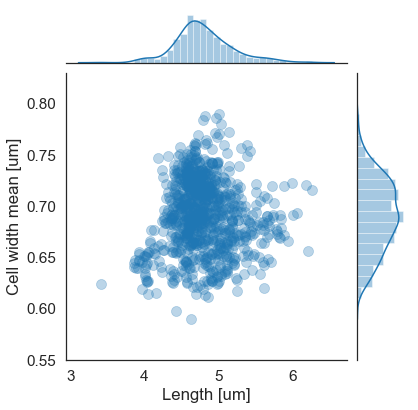

In [29]:
sns.set(font_scale = 1.4,style ="white")
plot2 = sns.JointGrid(x='Length [um]',y="Cell width mean [um]",data=filtered_data)
plot2 = plot2.plot_marginals(sns.distplot,color = "tab:blue")
plot2 = plot2.plot_joint(sns.scatterplot,color="tab:blue",alpha=0.3,s=100,edgecolor="tab:blue")
plot2.savefig("/Volumes/Sam/summary/Length_width.png")

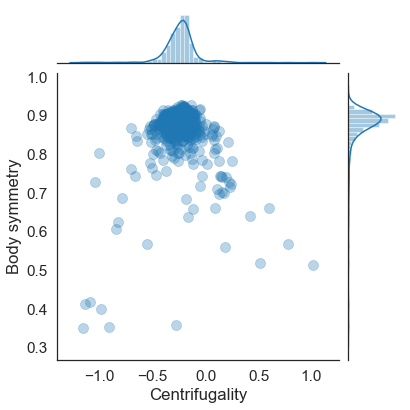

In [30]:
sns.set(font_scale = 1.4,style ="white")
plot3 = sns.JointGrid(x='Centrifugality',y='Body symmetry',data=filtered_data)
plot3 = plot3.plot_marginals(sns.distplot,color = "tab:blue")
plot3 = plot3.plot_joint(sns.scatterplot,color="tab:blue",alpha=0.3,s=100,edgecolor="tab:blue")
plot3.savefig("/Volumes/Sam/summary/Centrifugality_body_symmetry.png")

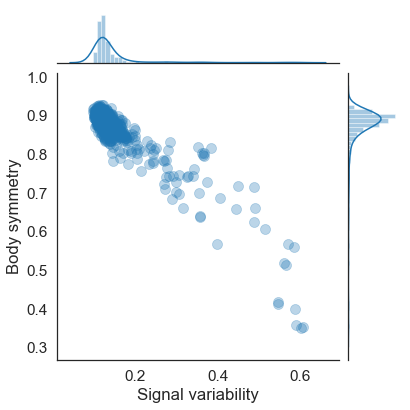

In [31]:
sns.set(font_scale = 1.4,style ="white")
plot4 = sns.JointGrid(x='Signal variability',y='Body symmetry',data=filtered_data)
plot4 = plot4.plot_marginals(sns.distplot,color = "tab:blue")
plot4 = plot4.plot_joint(sns.scatterplot,color="tab:blue",alpha=0.3,s=100,edgecolor="tab:blue")
plot4.savefig("/Volumes/Sam/summary/Variability_body_symmetry.png")

In [120]:
import umap

In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = StandardScaler().fit_transform(filtered_data)
principalComponents = pca.fit_transform(filtered_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

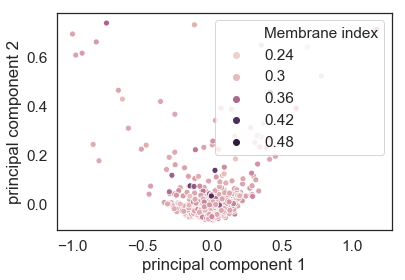

In [175]:
sns.scatterplot(principalDf['principal component 1'],principalDf['principal component 2'],\
                hue = filtered_data["Membrane index"])

In [42]:
filtered_data.head()

,Index,Image,Colony,Cell,Curvature,Length [um],Cell width mean [um],Cell width std [um],Perimeter [um],Fluorescent intensity mean,Fluorescent intensity std,SNR,Membrane index,Centrifugality,Signal variability,Signal variability on membrane,Body symmetry,Pole symmetry,Count,Sample_id
0,385.0,0.452659,63.268482,6.673152,26.104041,5.090687,0.634021,0.097341,10.895953,122.080156,48.808042,3.957173,0.312789,-0.184019,0.111192,0.263790,0.903301,0.867956,771,MSR10_07102019_Well_A01
1,267.0,0.491589,40.257944,15.398131,26.891278,5.036710,0.631645,0.097178,10.764374,128.221121,46.971215,4.129402,0.322030,-0.108751,0.105619,0.254920,0.902323,0.867574,535,MSR10_07102019_Well_A02
2,253.0,1.309665,52.471400,4.382643,27.102332,5.357219,0.687357,0.098600,11.476292,273.401381,93.496450,8.344103,0.313779,-0.229243,0.109243,0.264051,0.887073,0.846854,507,MSR10_07102019_Well_A05
3,201.0,0.761787,33.605459,8.632754,28.085627,5.516600,0.681439,0.100397,11.780670,243.862035,85.287841,7.463821,0.312779,-0.210194,0.112261,0.266022,0.879950,0.839380,403,MSR10_07102019_Well_A06
4,256.5,0.437743,81.023346,18.972763,26.366538,4.857004,0.668521,0.099844,10.458774,163.353307,61.896109,4.889416,0.318076,-0.179136,0.121940,0.273082,0.886870,0.844691,514,MSR10_07102019_Well_A07


In [49]:
features = ["Index","Length [um]","Membrane index","Centrifugality","Signal variability",\
            "Signal variability on membrane","Body symmetry","Pole symmetry"]
z_scores = filtered_data.copy()
for feature in features[1:]:
    z_scores[feature] = (filtered_data[feature] - filtered_data[feature].mean())/filtered_data[feature].std()

In [50]:
z_scores.head()

,Index,Image,Colony,Cell,Curvature,Length [um],Cell width mean [um],Cell width std [um],Perimeter [um],Fluorescent intensity mean,Fluorescent intensity std,SNR,Membrane index,Centrifugality,Signal variability,Signal variability on membrane,Body symmetry,Pole symmetry,Count,Sample_id
0,385.0,0.452659,63.268482,6.673152,26.104041,0.749585,0.634021,0.097341,10.895953,122.080156,48.808042,3.957173,-0.341478,0.355455,-0.458352,-0.400301,0.491154,0.502005,771,MSR10_07102019_Well_A01
1,267.0,0.491589,40.257944,15.398131,26.891278,0.609681,0.631645,0.097178,10.764374,128.221121,46.971215,4.129402,0.262077,0.826890,-0.536989,-0.599148,0.475828,0.496538,535,MSR10_07102019_Well_A02
2,253.0,1.309665,52.471400,4.382643,27.102332,1.440414,0.687357,0.098600,11.476292,273.401381,93.496450,8.344103,-0.276787,0.072203,-0.485856,-0.394441,0.236731,0.200077,507,MSR10_07102019_Well_A05
3,201.0,0.761787,33.605459,8.632754,28.085627,1.853519,0.681439,0.100397,11.780670,243.862035,85.287841,7.463821,-0.342094,0.191516,-0.443274,-0.350255,0.125062,0.093132,403,MSR10_07102019_Well_A06
4,256.5,0.437743,81.023346,18.972763,26.366538,0.143896,0.668521,0.099844,10.458774,163.353307,61.896109,4.889416,0.003838,0.386041,-0.306705,-0.192003,0.233543,0.169123,514,MSR10_07102019_Well_A07


In [52]:
np.abs(z_scores.iloc[2][features[2:]]).max()

0.4858564718424723

In [60]:
hit_list = []
for i in range(len(z_scores)):
    if np.abs(z_scores.iloc[i][features[2:]]).max()>1.5:
        hit_list.append(i)

In [75]:
data = np.asarray(z_scores.iloc[hit_list][features[2:]])

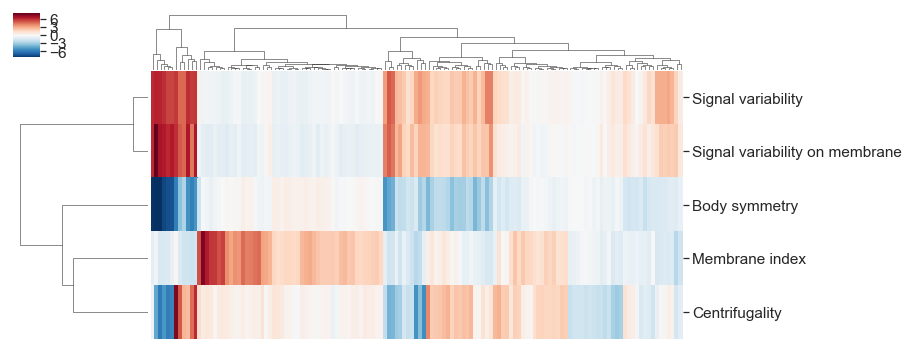

In [76]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
col_linkage = hierarchy.linkage(distance.pdist(data,metric="euclidean"), method='complete')
m = sns.clustermap(z_scores.iloc[hit_list][features[2:-1]].T, col_linkage=col_linkage,\
                   method="complete",cmap="RdBu_r",figsize=(12,6),xticklabels=False)
m.savefig("/Volumes/Sam/summary/clustermap.png",dpi=160)

In [78]:
len(hit_list)

135

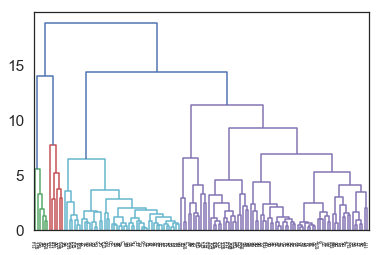

In [81]:
h = hierarchy.dendrogram(col_linkage)
n = 0
index_list = []
for i in [6,6,7,40,11,17,19,14,15]:
    index_list.append(h["leaves"][n:n+i])
    n+=i

In [83]:
hits = filtered_data.iloc[hit_list].copy().reset_index(drop=True)
hits["Group"] = [0] * len(hits)
group_val = 0
for group in index_list:
    temp = []
    for i in group:
        temp.append(hit_list[i])
    hits.loc[group,"Group"] = group_val
    group_val+=1

In [87]:
hits.sort_values(by="Group").reset_index(drop=True)
hits.to_excel("/Volumes/Sam/summary/hits_clustered.xls")

In [271]:
axial_data = np.load("/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/Well_A03_padded_demograph.npy")
lateral_data = np.load("/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/Well_A03_mean_lateral.npy")
well_summary = pd.read_excel("/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/Well_A03_summary.xls")

In [272]:
heatmap = axial_data[well_summary[well_summary["SNR"]>3].sort_values(by="Length [um]")["Index"]]
lateral_mean = np.average(lateral_data,axis=0)
lateral_std = np.std(lateral_data,axis=0)
average_mean = well_summary[well_summary["SNR"]>3]["Cell width mean [um]"].mean()
x_lateral = np.linspace(-0.5 * average_mean, 0.5 * average_mean, 100)

In [21]:
def scatter_plot_with_global_metric(fig,gridspec,grid_coordinate,global_mean_dict,well_data,key1,key2,\
                                    xrange=[],yrange=[],plot_std = False,dist_plot = False,dist_height = 3):
    if not dist_plot:
        (x1,x2,y1,y2) = grid_coordinate
    else:
        (x1,x2,y1,y2) = grid_coordinate
        x1 += dist_height
        y2 -= dist_height
    ax = fig.add_subplot(gridspec[x1:x2,y1:y2])
    sns.scatterplot(x=key1,y=key2,data=well_data,ax=ax,alpha = 0.2,s=25,edgecolor="tab:blue")
    ax.tick_params(axis="both",length=0)
    mean_1,std_1 = global_mean_dict[key1][0],global_mean_dict[key1][1]
    mean_2,std_2 = global_mean_dict[key2][0],global_mean_dict[key2][1]
    if plot_std:
        ax.axvspan(mean_1 - std_1, mean_1 + std_1,alpha=0.2,color="navy")
        ax.axhspan(mean_2 - std_2, mean_2 + std_2,alpha=0.2,color="navy")
    else:
        ax.axvline(mean_1,alpha=0.5,color="navy",linewidth=2,ls=':')
        ax.axhline(mean_2,alpha=0.5,color="navy",linewidth=2,ls=':')
    if len(xrange) != 0:
        ax.set_xticks(xrange)
    if len(yrange) != 0:
        ax.set_yticks(yrange)
    if dist_plot:
        ax2 = fig.add_subplot(gridspec[x1-dist_height:x1,y1:y2])
        ax3 = fig.add_subplot(gridspec[x1:x2,y2:y2+dist_height])
        sns.distplot(well_data[key1],ax=ax2)
        sns.distplot(well_data[key2],ax=ax3,vertical=True)
        if len(xrange) != 0:
            ax2.set_xticks(xrange)
        if len(yrange) != 0:
            ax3.set_yticks(yrange)
        ax2.axis("off")
        ax3.axis("off")

def read_well_data(well_folder,global_mean_dict,SNR_cutoff=2.4,min_cell_count = 50):
    #locate stored files
    enough_cells = False
    data1=glob.glob(well_folder+"*demograph.npy")
    data2=glob.glob(well_folder+"*mean_lateral.npy")
    data3= glob.glob(well_folder+"*summary.xls")
    if len(data1) != 1:
        raise ValueError("Can not locate data file(s)!")
    else:
        axial_data = np.load(data1[0])
        lateral_data = np.load(data2[0])
        well_summary = pd.read_excel(data3[0])
        filtered_data = well_summary[well_summary["SNR"]>SNR_cutoff]
        if len(filtered_data) >= min_cell_count:
            enough_cells = True
            heatmap = axial_data[filtered_data.sort_values(by="Length [um]")["Index"]]
            lateral_mean = np.average(lateral_data[filtered_data["Index"]],axis=0)
            lateral_std = np.std(lateral_data[filtered_data["Index"]],axis=0)
            summary_plot(heatmap,lateral_mean,lateral_std,\
                         filtered_data,global_mean_dict,well_folder)
        else:
            enough_cells = False

def summary_plot(heatmap,lateral_mean,\
                 lateral_std,\
                 filtered_data,\
                 global_mean_dict,\
                 output_folder):
    sns.set(font_scale = 1,style ="white")
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(40, 40)
    ax1 = fig.add_subplot(gs[2:24, 0:11])
    ax1.imshow(heatmap,cmap = "viridis",aspect="auto")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Normalized demograph\n(max length = 15μm)\nN=%d"%(len(heatmap)), fontsize=12)
    ax2 = fig.add_subplot(gs[26:36, 0:11])
    average_width = filtered_data["Cell width mean [um]"].mean()
    x_lateral = np.linspace(-0.5 * average_width, 0.5 * average_width, 100)
    ax2.plot(x_lateral,lateral_mean)
    ax2.fill_between(x_lateral, lateral_mean - lateral_std, lateral_mean + lateral_std, alpha=0.1)
    ax2.set_xlabel("Distance to midline [μm]", fontsize=12)
    ax2.text(0.5, 0.1, "normalized fluorecence\nalong lateral axis", fontsize=10,\
             horizontalalignment='center', transform=ax2.transAxes,\
             bbox=dict(facecolor='white', alpha=0.4))
    ax2.get_yaxis().set_visible(False)
    scatter_plot_with_global_metric(fig,gs,[0,10,15,40],\
                                    global_mean_dict,filtered_data,\
                                    "Length [um]","Cell width mean [um]",\
                                    xrange=np.linspace(0,15,6),\
                                    yrange=np.linspace(0.2,1.2,6),dist_plot=True)
    scatter_plot_with_global_metric(fig,gs,[13,23,15,40],\
                                    global_mean_dict,filtered_data,\
                                    "Fluorescent intensity mean","Length [um]",\
                                    yrange=np.linspace(0,15,6),dist_plot=True)
    scatter_plot_with_global_metric(fig,gs,[26,36,15,25],\
                                    global_mean_dict,filtered_data,\
                                    "Centrifugality","Membrane index",\
                                    xrange = np.linspace(-3,3,7),yrange=np.linspace(0.1,0.8,8),\
                                    dist_plot=True,dist_height=2)
    scatter_plot_with_global_metric(fig,gs,[26,36,29,39],\
                                    global_mean_dict,filtered_data,\
                                    "Signal variability","Pole symmetry",\
                                    xrange=np.linspace(0,1,6),yrange=np.linspace(0,1,6),\
                                    dist_plot=True,dist_height=2)
    fig.savefig(output_folder+"summary_plot.png",bbox_inches='tight',dpi=200)
    plt.close()

In [11]:
read_well_data("/Volumes/Sam/MSR10_IDW/plate10_raw_files/07102019_raw_files/output/Well_A01/",global_mean_dict)

In [22]:
#generate_summary_plots
wells = []
global_data = []
#plates = glob.glob("/Volumes/Sam/MSR*_IDW/")
plates = glob.glob("/Volumes/Sam/MSR13_IDW/")
for plate in plates:
    plate_name = plate.split("/")[-2][:-4]
    subfolder = glob.glob(plate+"*raw_files/")[0]
    if len(glob.glob(subfolder+"*raw_files/")) > 0:
        babyfolders = glob.glob(subfolder+"*raw_files/")
        for babyfolder in babyfolders:
            wells = glob.glob(babyfolder+"output/Well*/")
            batch = babyfolder.split("/")[-2][:-10]
            if len(wells)>0:
                for well in wells:
                    read_well_data(well,global_mean_dict)
    else:
        wells = glob.glob(subfolder+"output/Well*/")
        batch = subfolder.split("/")[-2][:-10]
        if len(wells)>0:
            for well in wells:
                read_well_data(well,global_mean_dict)

In [479]:
glob.glob("/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/*.npy")

['/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/Well_A03_mean_lateral.npy',
 '/Volumes/Sam/MSR_PP1_IDW/07072018_raw_files/output/Well_A03/Well_A03_padded_demograph.npy']

In [89]:
#initiate plate dict


In [23]:
def plate_SNR(plate):
    row_idx = ["A","B","C","D","E","F","G","H"]
    col_idx = [1,2,3,4,5,6,7,8,9,10,11,12]
    plate_dict = {}
    for r in row_idx:
        for c in col_idx:
            well = standardize_well(r,c)
            plate_dict[well] = []
    plate_name = plate.split("/")[-2][:-4]
    subfolder = glob.glob(plate+"*raw_files/")[0]
    if len(glob.glob(subfolder+"*raw_files/")) > 0:
        babyfolders = glob.glob(subfolder+"*raw_files/")
        for babyfolder in babyfolders:
            wells = glob.glob(babyfolder+"output/Well*/")
            batch = babyfolder.split("/")[-2][:-10]
            if len(wells)>0:
                for well in wells:
                    well_id = well.split("/")[-2][-3:]
                    if not well_id in plate_dict:
                        raise ValueError("Illegal input!")
                    else:
                        df = pd.read_excel(glob.glob(well+"*summary.xls")[0])
                        SNR = normalize_SNR(df["SNR"].mean())
                        plate_dict[well_id].append(SNR)
    else:
        wells = glob.glob(subfolder+"output/Well*/")
        batch = subfolder.split("/")[-2][:-10]
        if len(wells)>0:
            for well in wells:
                well_id = well.split("/")[-2][-3:]
                if not well_id in plate_dict:
                    raise ValueError("Illegal input!")
                else:
                    df = pd.read_excel(glob.glob(well+"*summary.xls")[0])
                    SNR = normalize_SNR(df["SNR"].mean())
                    plate_dict[well_id].append(SNR)
    fig,axes = initiate_plate(8,12)
    for key,vals in plate_dict.items():
        if vals == []:
            vals = [0]
        draw_well(axes,key,vals)
    return plate_dict,fig

8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12
8 12


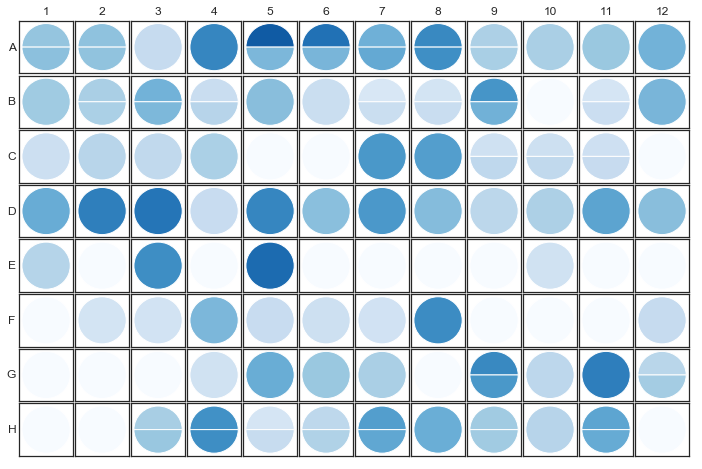

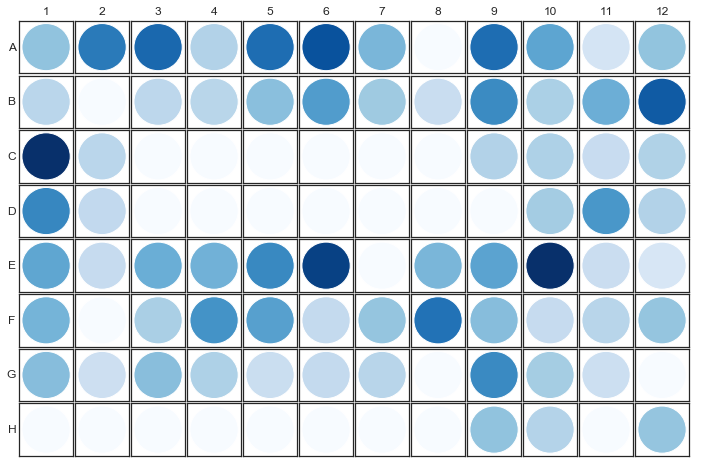

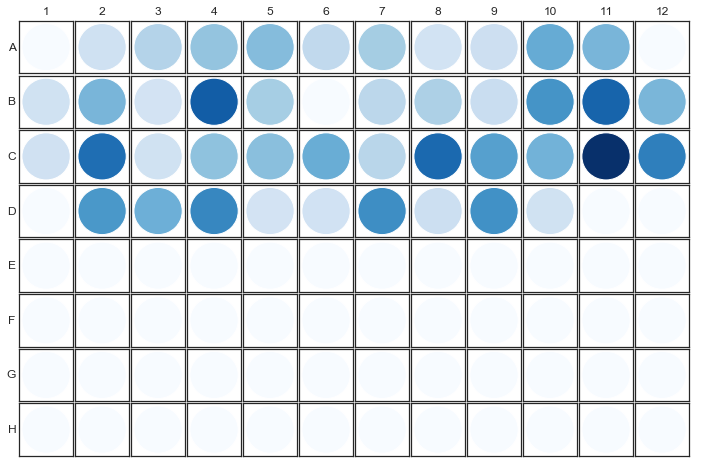

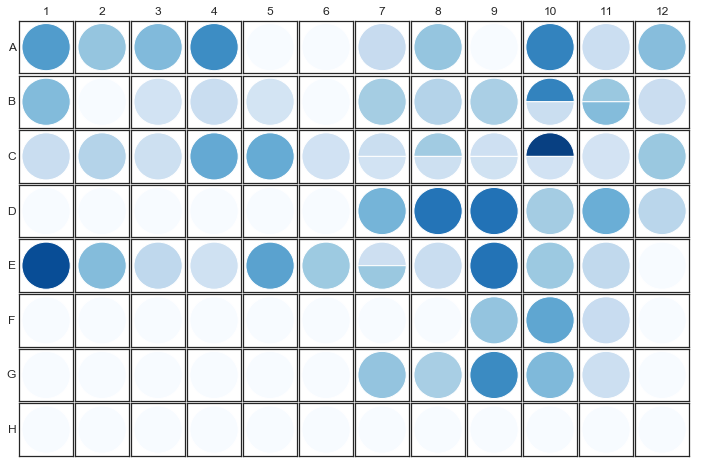

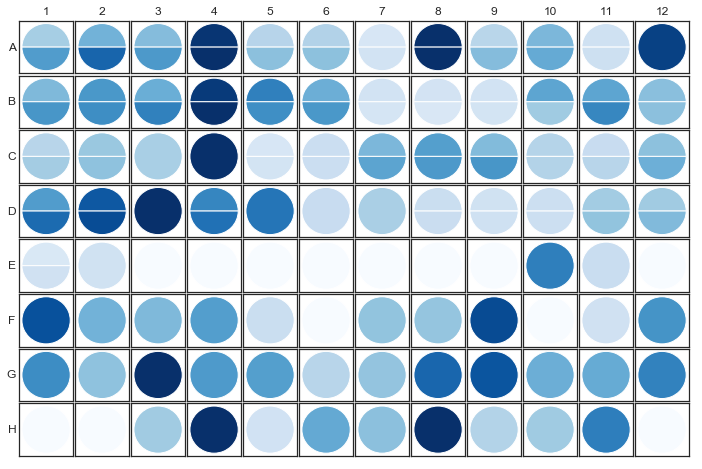

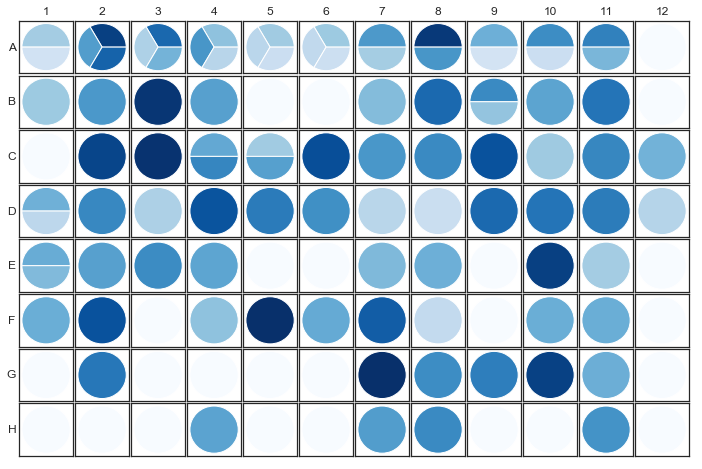

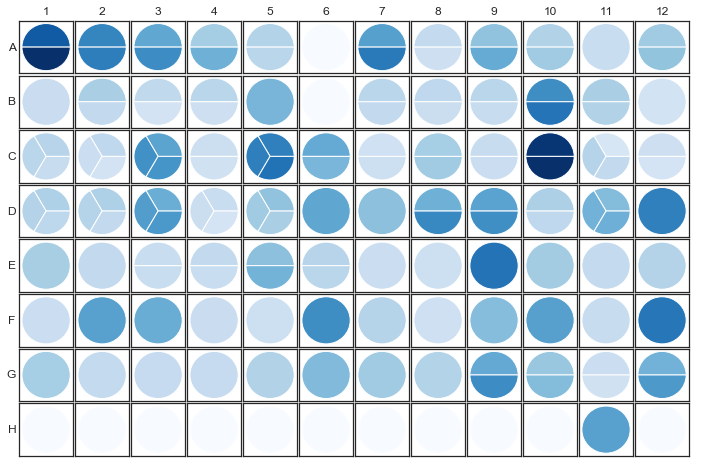

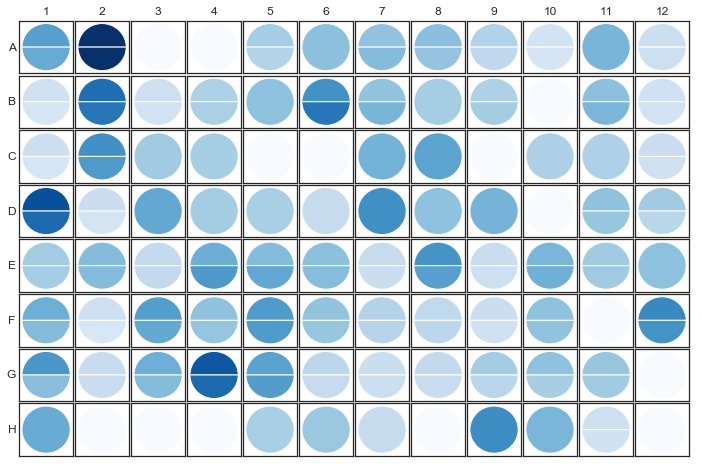

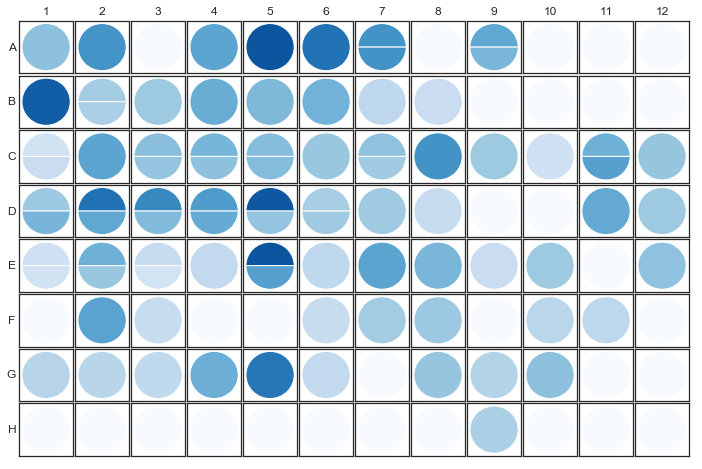

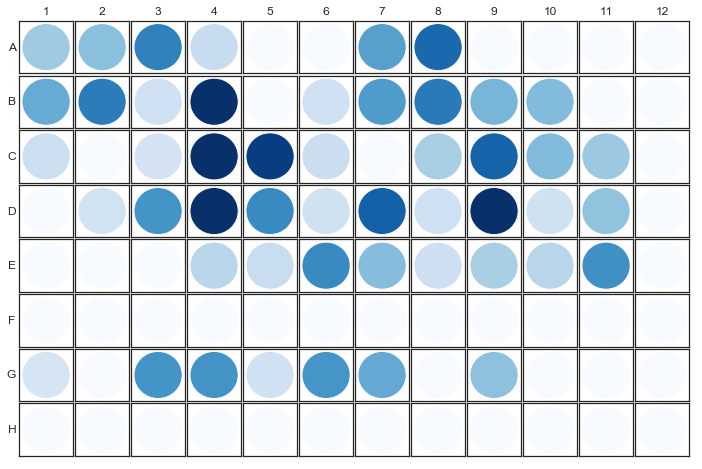

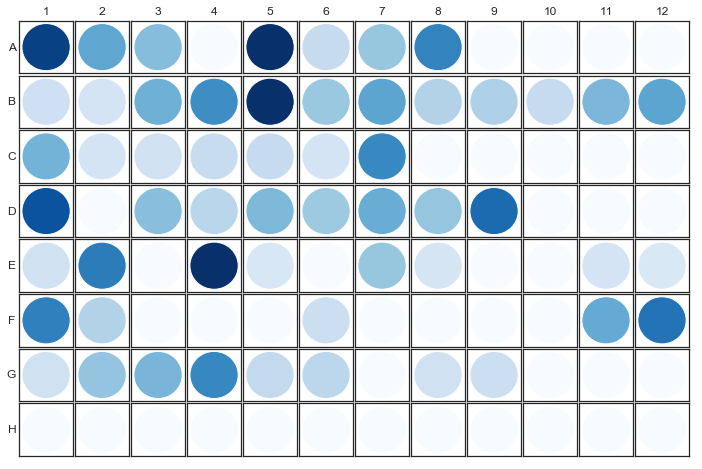

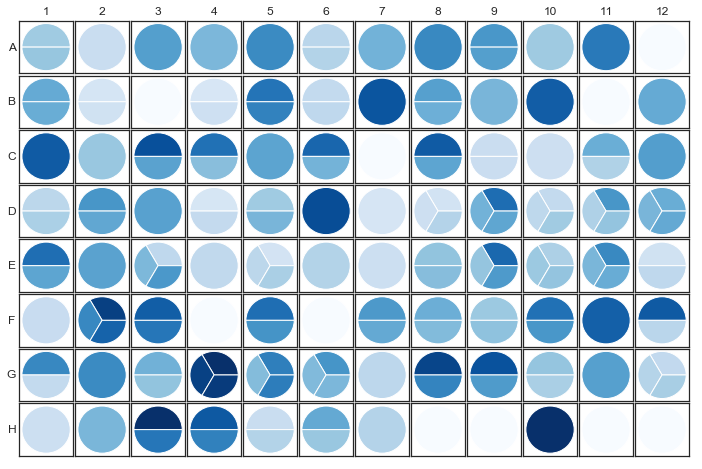

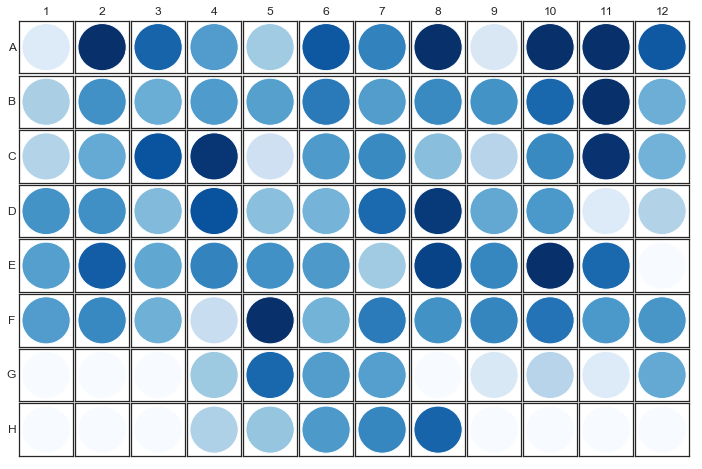

In [263]:
for plate in glob.glob("/Volumes/Sam/MSR*_IDW/"):
    a,b = plate_SNR(plate)
    b.savefig("/Volumes/Sam/summary/{}_plate_SNR.png".format(plate.split("/")[-2][:-4]),bbox_inches='tight')

Index                             218.000000
Image                               0.787185
Colony                             54.421053
Cell                               15.318078
Curvature                          27.612405
Length [um]                         4.042883
Cell width mean [um]                0.672952
Cell width std [um]                 0.108924
Perimeter [um]                      8.832723
Fluorescent intensity mean         38.519451
Fluorescent intensity std          29.359954
SNR                                 1.312563
Membrane index                      0.374542
Centrifugality                     -0.012078
Signal variability                  0.174368
Signal variability on membrane      0.314723
Body symmetry                       0.902458
Pole symmetry                       0.867007
Count                               3.000000
Name: mean, dtype: float64

In [141]:
rpsJ = im.IO.pickel_dump("/Users/jz-rolling/Desktop/rpsJ/rpsJ_FKBP_eGFP_colony11_022.nd2",\
                         "/Users/jz-rolling/Desktop/rpsJ/",\
                         "rpsJ",0)

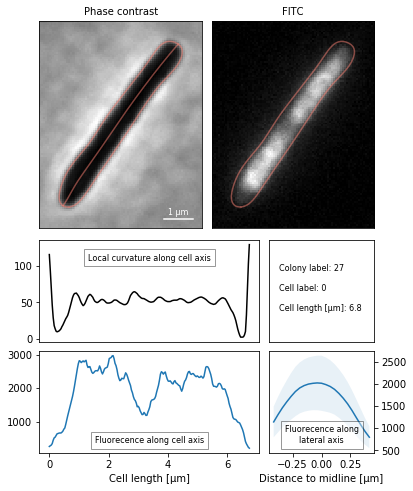

In [140]:
rpsJ.cells[29].plot_advanced(rpsJ)

In [154]:
m = create_metrics(pk.load(open("/Users/jz-rolling/Desktop/rpsJ/rpsJ_sample_0_cells.pk","rb")),"/Users/jz-rolling/Desktop/rpsJ/","1")

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x13735a2b0>)

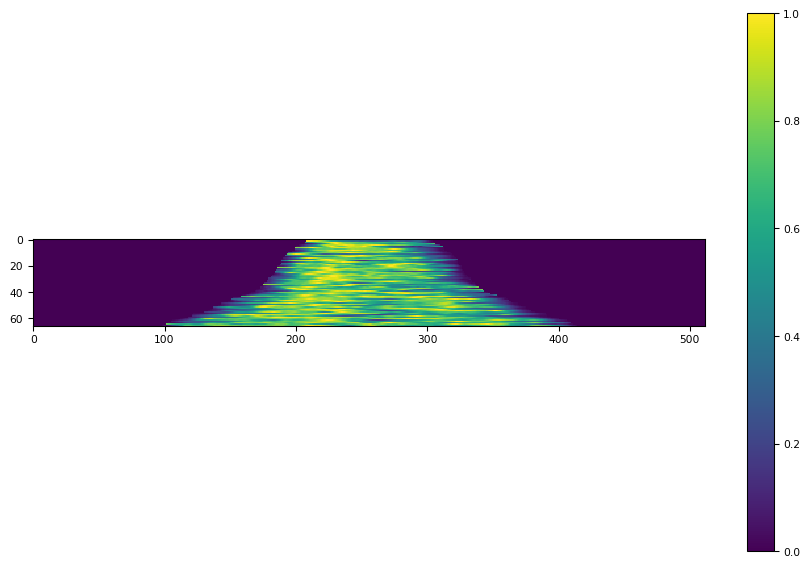

In [161]:
tifffile.imshow(np.load("/Users/jz-rolling/Desktop/rpsJ/1_padded_demograph.npy")[args])

In [157]:
df = pd.read_excel("/Users/jz-rolling/Desktop/rpsJ/1_summary.xls")

8 12


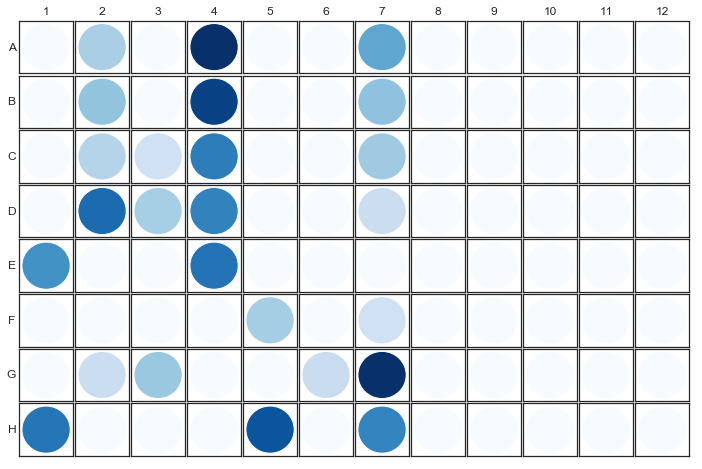

In [24]:
plate = "/Volumes/Sam/MSR13_IDW/"
a,b = plate_SNR("/Volumes/Sam/MSR13_IDW/")
b.savefig("/Volumes/Sam/summary/{}_plate_SNR.png".format(plate.split("/")[-2][:-4]),bbox_inches='tight')

In [43]:
features

['Index',
 'Length [um]',
 'Membrane index',
 'Centrifugality',
 'Signal variability',
 'Signal variability on membrane',
 'Body symmetry',
 'Pole symmetry']

In [89]:
hits

,Index,Image,Colony,Cell,Curvature,Length [um],Cell width mean [um],Cell width std [um],Perimeter [um],Fluorescent intensity mean,...,SNR,Membrane index,Centrifugality,Signal variability,Signal variability on membrane,Body symmetry,Pole symmetry,Count,Sample_id,Group
0,62.0,0.000000,32.208000,10.632000,26.647995,5.427120,0.684000,0.098080,11.604320,99.524800,...,3.396560,0.347280,-0.056600,0.114776,0.253664,0.917360,0.883512,125,MSR10_07102019_Well_B02,3
1,126.5,0.094488,71.039370,1.275591,22.498276,4.625118,0.725591,0.107874,10.049370,164.079528,...,5.045748,0.311622,-0.704685,0.343827,0.406394,0.762063,0.713386,254,MSR10_08162019_Well_G05,4
2,932.5,2.767417,51.578778,5.441586,28.201712,5.833044,0.668660,0.099100,12.381736,242.044802,...,7.014051,0.388786,-0.130385,0.122317,0.248839,0.870653,0.832613,1866,MSR10_08162019_Well_G11,3
3,1413.5,1.568600,95.715700,2.043847,24.605845,4.647171,0.705403,0.104922,10.077595,95.216832,...,3.321909,0.344758,-0.203744,0.127342,0.266079,0.907412,0.880878,2828,MSR11_08092019_Well_B10,3
4,257.5,0.000000,27.573643,22.240310,30.485844,5.470930,0.651860,0.103798,11.629767,115.779845,...,3.978992,0.305767,-0.400217,0.275705,0.311891,0.784938,0.748388,516,MSR11_08092019_Well_F12,8
5,302.0,0.763636,145.715702,3.328926,24.125139,4.437421,0.732231,0.119669,9.666149,135.737521,...,4.347140,0.361298,-0.208777,0.132337,0.269598,0.897198,0.867681,605,MSR12_07272019_Well_A05,3
6,1862.5,3.830381,195.831455,27.544552,25.147656,4.316017,0.713631,0.120467,9.417356,129.550725,...,3.523366,0.368902,-0.233904,0.158378,0.291091,0.865245,0.829425,3726,MSR12_07272019_Well_A07,3
7,628.0,3.030231,140.459825,2.057279,24.649565,4.527335,0.706189,0.106874,9.839531,280.406444,...,8.269833,0.308775,-0.555022,0.159267,0.287155,0.852874,0.809099,1257,MSR12_07272019_Well_B04,7
8,635.5,1.591981,163.272799,3.630503,24.258391,4.289064,0.707909,0.109277,9.352225,103.163129,...,3.494080,0.352283,-0.166191,0.125833,0.260505,0.907414,0.877980,1272,MSR12_07272019_Well_B05,3
9,1490.5,3.636486,223.642186,5.437626,23.950580,4.464799,0.707666,0.109970,9.701100,401.476794,...,7.991878,0.316111,-0.513979,0.193176,0.310883,0.852190,0.831122,2982,MSR12_07272019_Well_B11,7


In [ ]:
scatter_plot_with_global_metric()